# Exercise: Image Processing (PCA+SVM)

Here we'll take a look at a simple facial recognition example.
This uses a dataset available within scikit-learn consisting of a
subset of the [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/)
data.  Note that this is a relatively large download (~200MB) so it may
take a while to execute.

In [1]:
import numpy as np
from sklearn import datasets
lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                                       data_home='datasets')
lfw_people.data.shape

(1288, 1850)

If you're on a unix-based system such as linux or Mac OSX, these shell commands
can be used to see the downloaded dataset:

In [2]:
!ls datasets

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
!du -sh datasets/lfw_home

'du' is not recognized as an internal or external command,
operable program or batch file.


Let's visualize these faces to see what we're working with:

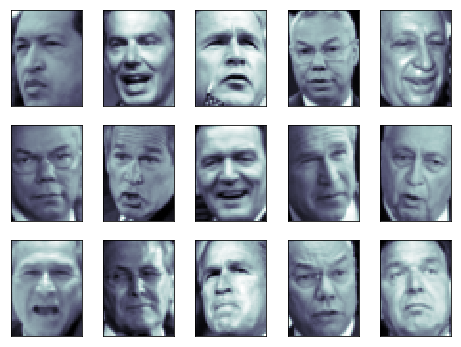

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
# plot several images
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(lfw_people.images[i], cmap=plt.cm.bone)

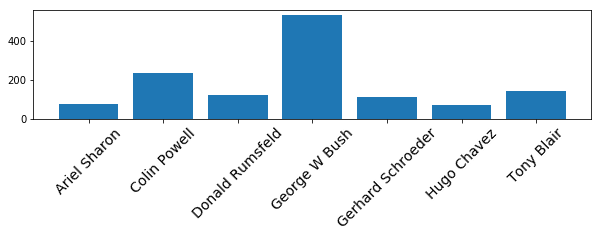

In [5]:
plt.figure(figsize=(10, 2))

unique_targets = np.unique(lfw_people.target)
counts = [(lfw_people.target == i).sum() for i in unique_targets]

plt.xticks(unique_targets, lfw_people.target_names[unique_targets])
locs, labels = plt.xticks()
plt.setp(labels, rotation=45, size=14)
_ = plt.bar(unique_targets, counts)

One thing to note is that these faces have already been localized and scaled
to a common size.  This is an important preprocessing piece for facial
recognition, and is a process that can require a large collection of training
data.  This can be done in scikit-learn, but the challenge is gathering a
sufficient amount of training data for the algorithm to work

Fortunately, this piece is common enough that it has been done.  One good
resource is [OpenCV](http://opencv.willowgarage.com/wiki/FaceRecognition), the
*Open Computer Vision Library*.

We'll perform a Support Vector classification of the images.  We'll
do a typical train-test split on the images to make this happen:

In [6]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(lfw_people.data, lfw_people.target, random_state=0)

print(X_train.shape, X_test.shape)

(966, 1850) (322, 1850)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Preprocessing: Principal Component Analysis

1850 dimensions is a lot for SVM.  We can use PCA to reduce these 1850 features to a manageable
size, while maintaining most of the information in the dataset.  Here it is useful to use a variant
of PCA called ``RandomizedPCA``, which is an approximation of PCA that can be much faster for large
datasets.  The interface is the same as the normal PCA we saw earlier:

In [7]:
from sklearn import decomposition
pca = decomposition.RandomizedPCA(n_components=150, whiten=True)
pca.fit(X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedPCA(copy=True, iterated_power=2, n_components=150,
       random_state=None, whiten=True)

One interesting part of PCA is that it computes the "mean" face, which can be
interesting to examine:

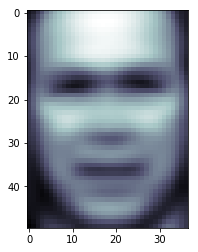

In [8]:
plt.imshow(pca.mean_.reshape((50, 37)), cmap=plt.cm.bone)

The principal components measure deviations about this mean along orthogonal axes.
It is also interesting to visualize these principal components:

In [9]:
print(pca.components_.shape)

(150, 1850)


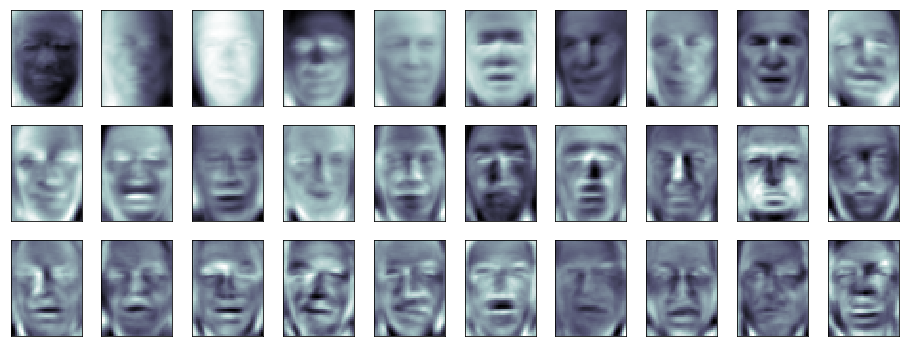

In [10]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape((50, 37)), cmap=plt.cm.bone)

The components ("eigenfaces") are ordered by their importance from top-left to bottom-right.
We see that the first few components seem to primarily take care of lighting
conditions; the remaining components pull out certain identifying features:
the nose, eyes, eyebrows, etc.

With this projection computed, we can now project our original training
and test data onto the PCA basis:

In [11]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
print(X_train_pca.shape)
print(X_test_pca.shape)

(966, 150)
(322, 150)


These projected components correspond to factors in a linear combination of
component images such that the combination approaches the original face.

## Doing the Learning: Support Vector Machines

Now we'll perform support-vector-machine classification on this reduced dataset:

In [13]:
from sklearn import svm
clf = svm.SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train)

SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Finally, we can evaluate how well this classification did.  First, we might plot a
few of the test-cases with the labels learned from the training set:

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

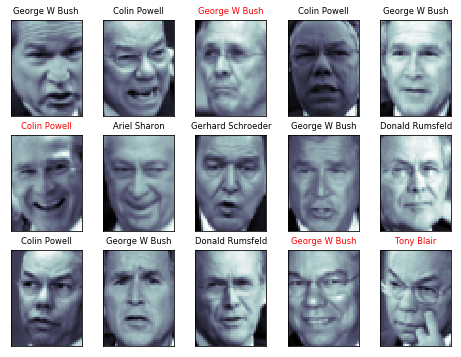

In [14]:
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test[i].reshape((50, 37)), cmap=plt.cm.bone)
    y_pred = clf.predict(X_test_pca[i])[0]
    color = 'black' if y_pred == y_test[i] else 'red'
    ax.set_title(lfw_people.target_names[y_pred], fontsize='small', color=color)

The classifier is correct on an impressive number of images given the simplicity
of its learning model!  Using a linear classifier on 150 features derived from
the pixel-level data, the algorithm correctly identifies a large number of the
people in the images.

Again, we can
quantify this effectiveness using one of several measures from the ``sklearn.metrics``
module.  First we can do the classification report, which shows the precision,
recall and other measures of the "goodness" of the classification:

In [15]:
from sklearn import metrics
y_pred = clf.predict(X_test_pca)
print(metrics.classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.71      0.80        28
     Colin Powell       0.79      0.87      0.83        63
  Donald Rumsfeld       0.95      0.79      0.86        24
    George W Bush       0.86      0.91      0.88       132
Gerhard Schroeder       0.81      0.85      0.83        20
      Hugo Chavez       0.93      0.64      0.76        22
       Tony Blair       0.82      0.85      0.84        33

      avg / total       0.85      0.85      0.85       322



Another interesting metric is the *confusion matrix*, which indicates how often
any two items are mixed-up.  The confusion matrix of a perfect classifier
would only have nonzero entries on the diagonal, with zeros on the off-diagonal.

In [16]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 20   4   0   3   1   0   0]
 [  1  55   0   4   0   1   2]
 [  0   2  19   3   0   0   0]
 [  1   8   1 120   0   0   2]
 [  0   0   0   1  17   0   2]
 [  0   1   0   5   2  14   0]
 [  0   0   0   4   1   0  28]]


In [17]:
print(metrics.f1_score(y_test, y_pred,average="micro"))

0.847826086957


## A Quick Note on Facial Recognition

Here we have used PCA "eigenfaces" as a pre-processing step for facial recognition.
The reason we chose this is because PCA is a broadly-applicable technique, which can
be useful for a wide array of data types.  Research in the field of facial recognition
in particular, however, has shown that other more specific feature extraction methods
are can be much more effective.